توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [2]:
%%capture

!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip
!unzip release_test.zip
!pip install mmengine

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob

from cv2 import imread as IM
from os import path

from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split

from random import randint
import matplotlib.pyplot as plt

## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




In [4]:
# function 1
import torchvision.transforms.functional as F

def displacement(img):
  dx = torch.randint(-60, 60, (1,)).item()
  dy = torch.randint(-60, 60, (1,)).item()
  img = F.affine(img, angle=0, translate=(dx, dy), scale=1, shear=0, fill=torch.mean(img).item())
  
  return img

# function 2
def rotation(img):
  angle = torch.randint(-30, 30, (1,)).item()
  img = F.affine(img, angle=angle, translate=(0, 0), scale=1, shear=0, fill=torch.mean(img).item())

  return img


# function 3
def scaling(img):
  scale = torch.randint(1, 3, (1,)).item()
  scale = scale/2
  img = F.affine(img, angle=0, translate=(0, 0), scale=scale, shear=0, fill=torch.mean(img).item())

  return img



# function 4
def Brightness(img):  ## for augmentation
  brightness = torch.randint(0, 255, (1,)).item()
  img = F.adjust_brightness(img, brightness)

  return img


# function 5
def bluring(img):# for augmentation
  img = cv2.GaussianBlur(img, (5, 5), 0)

  return img

# function 6
def gaussian_noise(img):#for augmentation
  gaussian = np.random.normal(0, 1, (224, 224))

  for i in range(img.shape[2]):
    img[:, :, i] += gaussian

  img = np.clip(img, 0, 255)
  img = img.astype(np.uint8)

  return img


<div dir="rtl">
<font face="B Nazanin" size="5">
دیتاست را این گونه تعریف می کنیم. در هر بار ایتریشن یک آرایه رندوم وان هات که هر کدام از المان های آن نماینده یک تغییر هستند ساخته می شود، بعد با استفاده از آن بردار تصویر را تغییر می دهیم و در آخر خود تصویر را به همراه تغییر یافته آن و بردار تغییرات اعمالی را در خروجی قرار می دهیم. مدل ما هم قرار است همین بردار تغییرات را پیش بینی کند
</font>
</div>

In [5]:
class CustomDataset(Dataset):

    def __init__(self,dataset):
        self.dataset = dataset

    def __getitem__(self,idx):
      img = self.dataset[idx][0]
      changes = np.random.randint(0,2,3)
      if sum(changes) == 0:
        change = randint(0,2)
        changes[change] = 1

      changed_image = img
      if changes[0] == 1:
        changed_image = displacement(changed_image)
      if changes[1] == 1:
        changed_image = rotation(changed_image)
      if changes[2] == 1:
        changed_image = scaling(changed_image)
      
      return img,changed_image,changes

    def __len__(self):
      return len(self.dataset)


In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


test_dataset    = datasets.ImageFolder('release_test', transform=transform)
dataset_test    = CustomDataset(test_dataset)

train_dataset   = datasets.ImageFolder('ADEChallengeData2016', transform=transform)
# use train test split to split the training data into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

dataset_train   = CustomDataset(train_dataset)
dataset_val     = CustomDataset(val_dataset)


train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader= DataLoader(dataset_test, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=True)


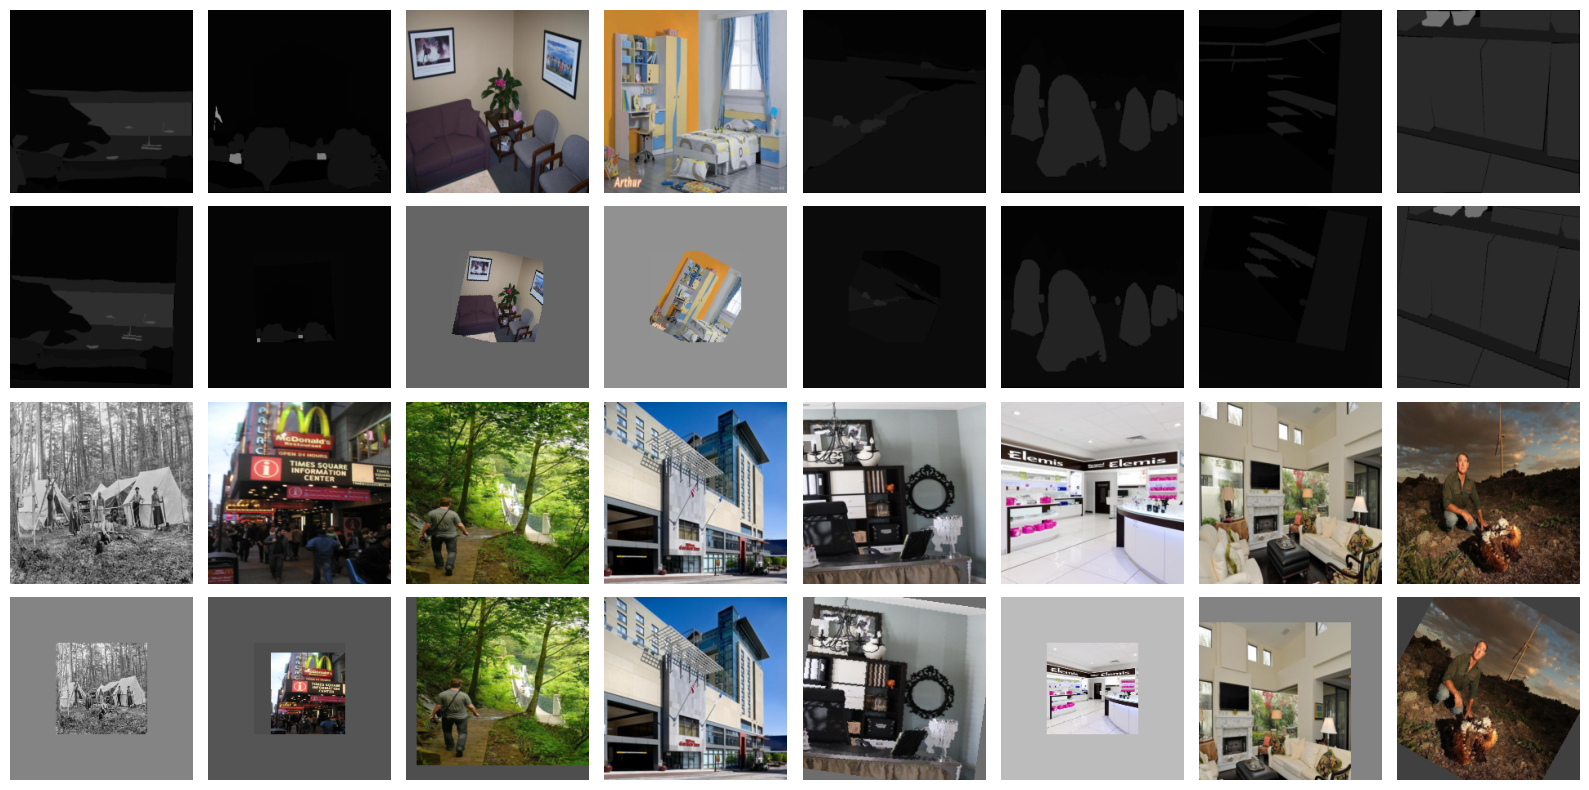

In [7]:
## To Do  : show 8 images from train_loader & 8 images from test_loader
dataiter = iter(train_loader)
images, changed_images, changes = next(dataiter)


fig, axes = plt.subplots(4, 8, figsize=(16, 8))
axes = axes.flatten()

for i in range(8):
    axes[i].imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
    axes[i].axis('off')
    axes[i+8].imshow(np.transpose(changed_images[i].numpy(), (1, 2, 0)))
    axes[i+8].axis('off')


dataiter = iter(test_loader)
images, changed_images, changes = next(dataiter)

for i in range(8):
    axes[i+16].imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
    axes[i+16].axis('off')
    axes[i+24].imshow(np.transpose(changed_images[i].numpy(), (1, 2, 0)))
    axes[i+24].axis('off')

plt.tight_layout()
plt.show()



##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

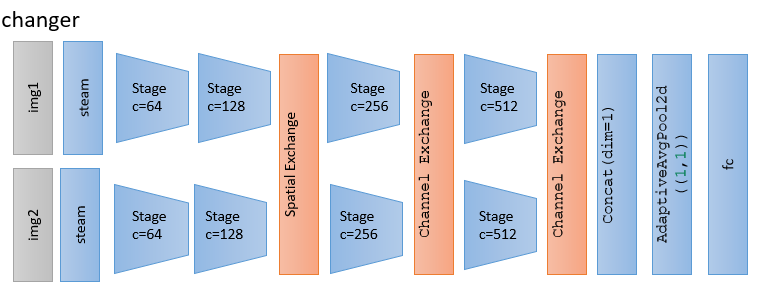

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


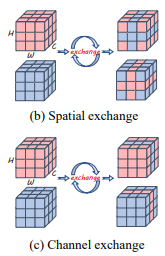

In [8]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

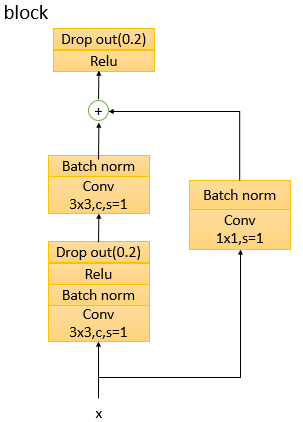

<div dir="rtl">
<font face="B Nazanin" size="5">
سوالات تئوری :

1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)

 تعداد کانال خروجی برای کانولوشن باتل نک را برابر با یک در نظر گرفتم و از پدینگ صفر استفاده کردم

2.  دلیل استفاده از کانولوشن 1در1 چیست؟
احتمالا برای ایجاد یک نوع از اتنشن
</font>
</div>


In [9]:
##To Do
class block(nn.Module):
  def __init__(self,cin,c):
    super(block,self).__init__()

    self.conv1    = nn.Conv2d(cin, c, 3, padding=1)
    self.bnorm1   = nn.BatchNorm2d(c)
    self.relu1    = nn.ReLU()
    self.dropout1  = nn.Dropout(0.2)

    self.conv2    = nn.Conv2d(c, c, 3, padding=1)
    self.bnorm2   = nn.BatchNorm2d(c)

    self.conv_skip    = nn.Conv2d(cin, 1, 1)
    self.bnorm_skip   = nn.BatchNorm2d(1)

    self.relu2    = nn.ReLU()
    self.dropout2 = nn.Dropout(0.2)

  def forward(self,x):
    out = self.conv1(x)
    out = self.bnorm1(out)
    out = self.relu1(out)
    out = self.dropout1(out)

    out = self.conv2(out)
    out = self.bnorm2(out)

    out = out + self.bnorm_skip(self.conv_skip(x))

    out = self.relu2(out)
    out = self.dropout2(out)

    return out

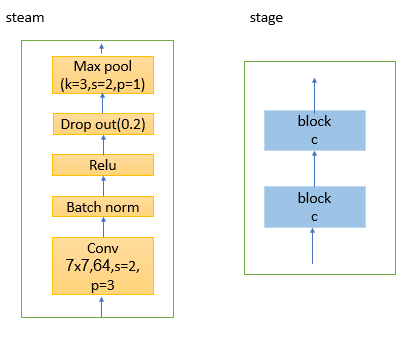

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [10]:
#To Do
class changer(nn.Module):
  def __init__(self,block,SpatialExchange,ChannelExchange):
    super(changer,self).__init__()

    self.SpatialEx = SpatialExchange(p=1/2)
    self.ChannelEx = ChannelExchange(p=1/2)

    self.steam=nn.Sequential(
          nn.Conv2d(3, 64, 7, stride = 2, padding = 3),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.MaxPool2d(3, stride = 2, padding = 1),
        )

    self.stage1=nn.Sequential(
          block(cin = 64, c = 64),
          block(cin = 64, c = 64),
        )
    self.stage2=nn.Sequential(
          block(cin = 64, c = 128),
          block(cin = 128, c = 128),
        )
    self.stage3=nn.Sequential(
          block(cin = 128, c = 256),
          block(cin = 256, c = 256),
        )
    self.stage4=nn.Sequential(
          block(cin = 256, c = 512),
          block(cin = 512, c = 512),
        )
    
    self.fc = nn.Linear(1024, 3)
    self.sigmoid=nn.Sigmoid()

  def _make_stage(self,):

    layers=[]

  
    return nn.Sequential(*layers)


  def forward(self,x1,x2):
    # path 1
    out1 = self.steam(x1)
    out1 = self.stage1(out1)
    out1 = self.stage2(out1)

    # path 2
    out2 = self.steam(x2)
    out2 = self.stage1(out2)
    out2 = self.stage2(out2)

    # spatial exchange
    out1, out2 = self.SpatialEx(out1, out2)

    out1 = self.stage3(out1)
    out2 = self.stage3(out2)

    # channel exchange
    out1, out2 = self.ChannelEx(out1, out2)

    out1 = self.stage4(out1)
    out2 = self.stage4(out2)

    # final channel exchange
    out1, out2 = self.ChannelEx(out1, out2)

    out = torch.cat((out1, out2), 1)
    out = nn.AdaptiveAvgPool2d((1,1))(out)
    out = nn.Flatten()(out)
    out = self.fc(out)
    out = self.sigmoid(out)

    return out

<div dir="rtl">
<font face="B Nazanin" size="5">
در بعد از لایه fc یک تابع فعال سازی سیگموید قرار می دهیم .
با این کار خروجی به اعداد بین 0 و یک محدود می شود . برای اینفرنس نیز خروجی را با یک ترشولد مقایسه می کنیم
اگر از آن ترشولد بزرگ تر بود آن را برابر با یک و اگر کوچک تر بود آن را برابر با صفر در نظر می گیریم.
</font>
</div>

In [11]:
## To Do
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = changer(block,SpatialExchange,ChannelExchange)

citeration = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

##Train & validation


In [17]:
model.to(device)
Loss_train=[]
Loss_val=[]

for epoch in range(5):
    for img, changed_img, changes in train_loader:
        img = img.to(device)
        changed_img = changed_img.to(device)
        changes = changes.float().to(device)

        optimizer.zero_grad()
        output = model(img, changed_img)
        loss = citeration(output, changes)
        loss.backward()
        optimizer.step()

    print(f'epoch {epoch}, loss {loss.item()}')

threshold = 0.7

with torch.no_grad():
    Sum_loss = 0
    num_correct_train = 0
    
    for img, changed_img, changes in train_loader:
        img = img.to(device)
        changed_img = changed_img.to(device)
        changes = changes.float().to(device)
    
        output = model(img, changed_img)
        loss = citeration(output, changes)
        Sum_loss += loss.item()

        output[output >= threshold] = 1
        output[output < threshold]  = 0
        num_correct_train += torch.sum(output == changes).item()
    
    loss_val = 0
    num_correct_val = 0
    for img, changed_img, changes in val_loader:
        img = img.to(device)
        changed_img = changed_img.to(device)
        changes = changes.float().to(device)
    
        output = model(img, changed_img)
        loss = citeration(output, changes)
        loss_val += loss.item()

        output[output >= threshold] = 1
        output[output < threshold]  = 0
        num_correct_val += torch.sum(output == changes).item()

print(f'loss_TRAIN ={Sum_loss:.3f},acc_train={(num_correct_train)},\t loss_val= {loss_val:.3f}, acc_val={(num_correct_val)}')
# save the model
torch.save(model.state_dict(), 'model.pth')



epoch 0, loss 1.8059114217758179

epoch 1, loss 1.7915489673614502

epoch 2, loss 1.5011343955993652

epoch 3, loss 1.669542908668518

epoch 4, loss 1.397692084312439

loss_TRAIN =1762.413,acc_train=75518,	 loss_val= 443.787, acc_val=18806


<div dir="rtl">
<font face="B Nazanin" size="5">
مقدار گزارش شده برای دقت آموزش و صحت سنجی برابر با 70 درصد است.
</font>
</div>

#Test


In [14]:
checkpoint = torch.load('model.pth')
model = changer(block,SpatialExchange,ChannelExchange)
model.load_state_dict(checkpoint)
model.to(device)
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

threshold = 0.7
with torch.no_grad():
    loss_test = 0
    acc_test = 0
    num_lost_test = 0
    for img, changed_img, changes in test_loader:
        img = img.to(device)
        changed_img = changed_img.to(device)
        changes = changes.float().to(device)

        output = model(img, changed_img)
        loss = citeration(output, changes)
        loss_test += loss.item()

        output[output >= threshold] = 1
        output[output < threshold]  = 0
        acc_test += torch.sum(output == changes).item()
        num_lost_test += torch.sum(output != changes).item()

print(f'loss_test= {loss_test:.3f}, acc_test = {acc_test*100/(num_lost_test + acc_test):.3f}%')


loss_test= 166.818, acc_test = 71.350%


<div dir="rtl">
<font face="B Nazanin" size="5">

سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟

به نظر می رسد چون شبکه تعداد بیشتری داده با دو تغییر دیده در پیدا کردن آن ها بهتر عمل کند اما در صورت برابری تعداد دیتا تشخیص یک تغییر به تنهایی باید ساده تر باشد.

</font>
</div>